# Tolkbar Maskinlæring

Denne jupyter notebooken er laga i samband med While1Create 25 April 2023.
Her tek vi for oss litt kodeeksempel frå diverse pythonbibliotek. 

## Importer bibliotek og datasett

Last inn naudsynte bibliotek, datasettet me nytter er [UCL Bike Sharing Dataset](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

In [10]:
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

## Rydd litt i dataen

In [11]:
data = pd.read_csv('data/day.csv')
data = data.set_index('dteday')
# De-normaliser temperatur
data['temp'] = data['temp'] * (39 - (-8)) + (-8)
data['atemp'] = data['atemp'] * (50 - (-16)) + (-16)
data['windspeed'] = data['windspeed'] * 67
data['hum'] = data['hum'] * 100

# Fjern verdier som ikkje er av interesse
data = data.drop(
    [
        'instant',
        'registered',
        'casual',
        'atemp'
    ],
    axis = 1
)

# Oversett
numeric_var = {
                "season": {1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'},
                "weathersit" : {1:'Clear', 2:'Mist', 3:'Rain', 4:'Rain'}
            }
data = data.replace(numeric_var)

# Gjer om kategorisk til binær
onehot = pd.get_dummies(data.season, prefix="season")
data = data.drop('season', axis=1)
data = data.join(onehot)

# Gjer om kategorisk til binær
onehot = pd.get_dummies(data.weathersit, prefix="weather")
data = data.drop('weathersit', axis=1)
data = data.join(onehot)

data

,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,cnt,season_Fall,season_Spring,season_Summer,season_Winter,weather_Clear,weather_Mist,weather_Rain
dteday,,,,,,,,,,,,,,,,
2011-01-01,0,1,0,6,0,8.175849,80.5833,10.749882,985,0,0,0,1,0,1,0
2011-01-02,0,1,0,0,0,9.083466,69.6087,16.652113,801,0,0,0,1,0,1,0
2011-01-03,0,1,0,1,1,1.229108,43.7273,16.636703,1349,0,0,0,1,1,0,0
2011-01-04,0,1,0,2,1,1.400000,59.0435,10.739832,1562,0,0,0,1,1,0,0
2011-01-05,0,1,0,3,1,2.666979,43.6957,12.522300,1600,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,12,0,4,1,3.945849,65.2917,23.458911,2114,0,0,0,1,0,1,0
2012-12-28,1,12,0,5,1,3.906651,59.0000,10.416557,3095,0,0,0,1,0,1,0
2012-12-29,1,12,0,6,0,3.906651,75.2917,8.333661,1341,0,0,0,1,0,1,0


## Hent ut variablar

- X: Uavhengige variablar (Forklaringsvariablar)
- y: Avhengig variabel (Responsvariabel)

Desse må konverterast til numpy arrays da scikit-learn krever det. Dette gjer ein
ved .values på slutten av ein Pandas Dataframe

In [18]:
y, X = dmatrices(
    'cnt ~ season_Spring + season_Summer + season_Fall + weather_Clear + weather_Rain + workingday + yr + holiday + workingday + temp + hum + windspeed', 
    data=data, return_type='dataframe'
)

## Tren lineær regresjon

In [19]:
mod = sm.OLS(y, X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     303.1
Date:                Tue, 25 Apr 2023   Prob (F-statistic):          2.63e-261
Time:                        08:04:05   Log-Likelihood:                -5937.6
No. Observations:                 731   AIC:                         1.190e+04
Df Residuals:                     719   BIC:                         1.195e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2029.6825    261.108      7.773      0.000    1517.057    2542.308
season_Spring  1137.9377    113.554     10.021      0.000     915.001    1360.874
season_Summer   844.1024    149.970      5.628      0.000     549.671    1138.534
season_Fall    1545.5895     96.672     15.988      0.000    1355.796    1735.383
weather_Clear   426.7212     81.238      5.253      0.000     267.229     586.214
weather_Rain  -1490.2286    194.550     -7.660      0.000   -1872.182   -1108.275
workingday      118.1934     67.915      1.740      0.082     -15.142     251.529
yr             2013.7111     61.752     32.610      0.000    1892.476    2134.947
holiday        -624.0107    188.439     -3.311      0.001    -993.967    -254.054
temp            108.6823      6.532     16.640      0.000      95.859     121.505
hum             -13.2564      2.951     -4.493      0.000     -19.049      -7.463
windspeed       -41.7207      6.389     -6.530      0.000     -54.264     -29.177
==============================================================================
Omnibus:                       84.257   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.410
Skew:                          -0.635   Prob(JB):                     8.24e-44
Kurtosis:                       5.213   Cond. No.                         602.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

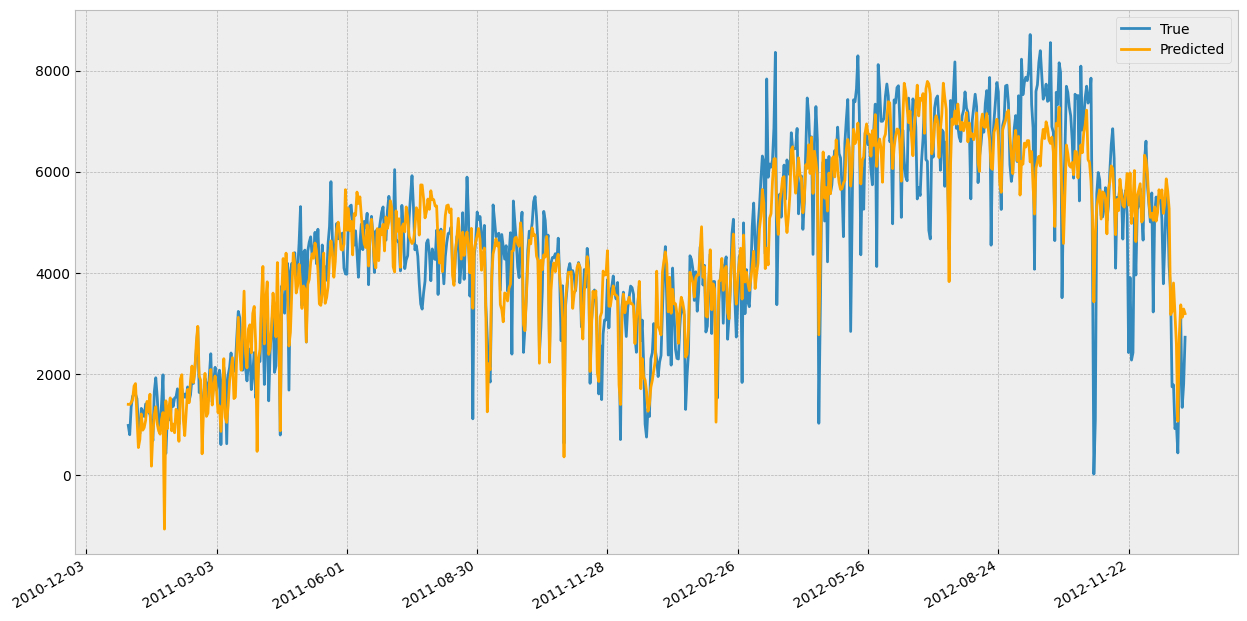

In [20]:
y_true = y
y_true.index = pd.to_datetime(y_true.index)
y_pred = res.predict(X)
y_pred.index = pd.to_datetime(y_pred.index)

plt.style.use('bmh')
fig, ax = plt.subplots()
fig.set_size_inches(15,8)
ax.plot(y_true.index, y_true, label='True')
ax.plot(y_pred.index, y_pred, label='Predicted', color='orange')
ax.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=90))
plt.gcf().autofmt_xdate()

## Vekt illustrasjon

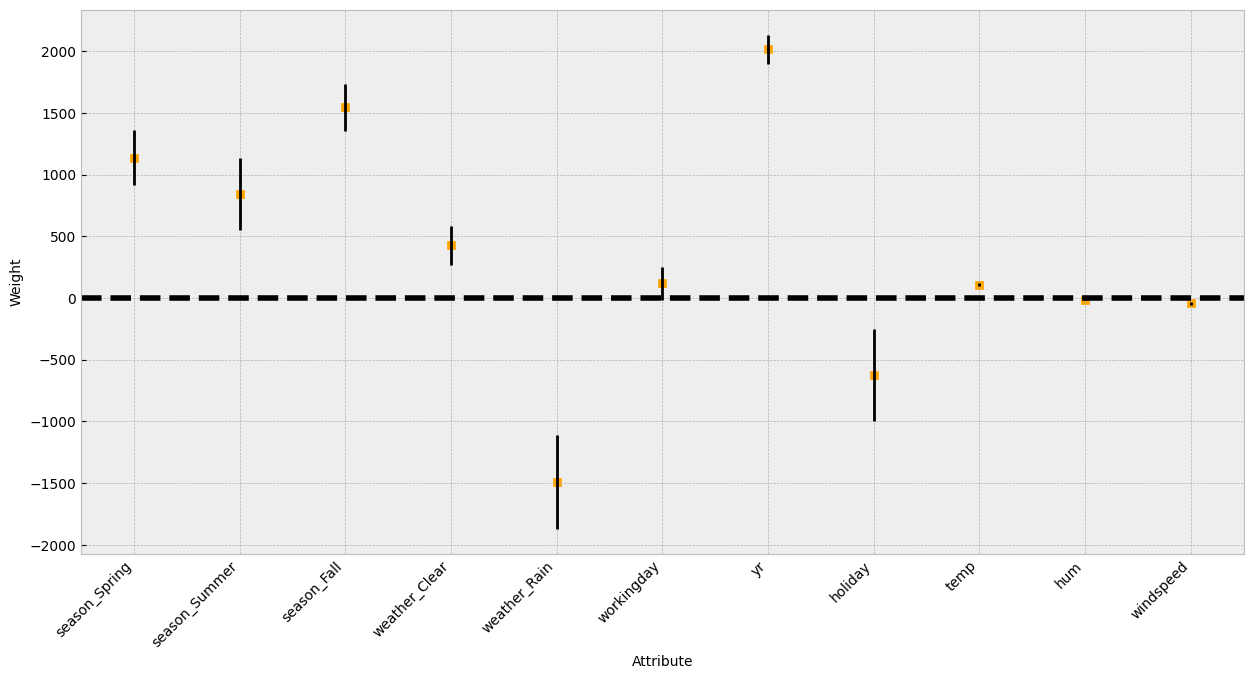

In [21]:
err_series = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef': res.params.values[1:],
                        'err': err_series.values[1:],
                        'varname': err_series.index.values[1:]
                       })


fig, ax = plt.subplots(figsize=(15, 8))
plt.style.use('bmh')
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

ax.set_ylabel('Weight')
ax.set_xlabel('Attribute')

ax.scatter(x=np.arange(coef_df.shape[0]), 
           marker='s', s=30, 
           y=coef_df['coef'], color='orange')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
fig.autofmt_xdate(rotation=45)

## Effekt Illustrasjon



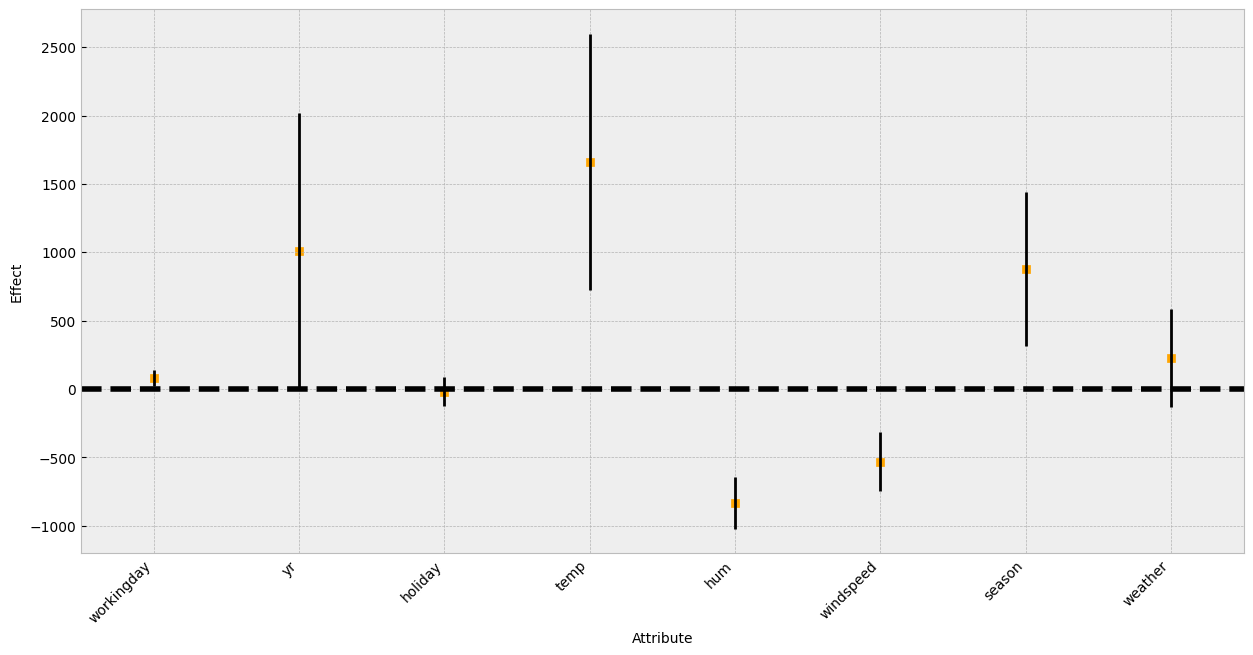

In [22]:
coef_df = pd.DataFrame({'coef': res.params.values[:]
                       },
                       index=res.params.index)

effect = pd.DataFrame()

for column in X:
    effect[column] = X[column] * coef_df.loc[column].values[0]

# Merge dummies
effect['season'] = effect['season_Spring'] + effect['season_Summer'] + \
    effect['season_Fall']
effect = effect.drop([
    'season_Spring', 'season_Summer', 'season_Fall'
], axis=1)

# Merge dummies
effect['weather'] = effect['weather_Clear'] + \
      effect['weather_Rain']
      
effect = effect.drop([
    'weather_Clear', 'weather_Rain'
], axis=1)

# Transformer dataframe til format for plot
plotdf = effect.describe().T
plotdf = plotdf.reset_index()
plotdf = plotdf.rename(
    columns={'mean' : 'coef', 'std' : 'err', 'index' : 'varname'}
) 

# Fjern Intercept
plotdf = plotdf[1:]

fig, ax = plt.subplots(figsize=(15, 8))
plt.style.use('bmh')
plotdf.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)

ax.set_ylabel('Effect')
ax.set_xlabel('Attribute')

ax.scatter(x=np.arange(plotdf.shape[0]), 
           marker='s', s=30, 
           y=plotdf['coef'], color='orange')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
fig.autofmt_xdate(rotation=45)